<h1 style = "font-size:300%; text-align:center;color:#0000FF; letter-spacing: 2px;padding: 10px;border-bottom: 5px solid #407A68"> Obesity Risk Prediction (Multi-Class) </h1>

In [25]:
import os;
import tensorflow as tf
import random as rn
os.environ['PYTHONHASHSEED'] = '51'
rn.seed(89)
tf.random.set_seed(40)

# Introduction
<div style="font-size:120%"> 
    <b>Goal:</b> We have to predict obesity risk in individuals.<br><br>
    <b>Dataset Description:</b>
</div>

| Column | Full Form | Description| 
|---|---|---|
| 'id'| id | Unique for each person(row)|
|'Gender'| Gender| person's Gender|
| 'Age' | Age| Dtype is float. Age is between 14 years to 61 years |
|'Height'| Height | Height is in meter it's between 1.45m to 1.98m|
| 'Weight' | Weight| Weight is between 39 to 165. I think it's in KG.|
|'family_history_with_overweight'| family history <br> with overweight| yes or no question|
| 'FAVC'| Frequent consumption <br> of high calorie food| it's yes or no question. i think question they asked is <br>do you consume high calorie food|
|'FCVC'|  Frequency of <br>consumption of vegetables| Similar to FAVC. this is also `yes or no` question|
|'NCP'| Number of main meals| dtype is float, NCP is between 1 & 4. I think it should be 1,2,3,4 <br>but our data is synthetic so it's taking float values|
|'CAEC'| Consumption of <br>food between meals| takes 4 values `Sometimes`, `Frequently`, `no` & `Always` <br>|
| 'SMOKE'| Smoke | yes or no question. i think the question is "Do you smoke?" |
|'CH2O'| Consumption of <br>water daily| CH2O takes values between 1 & 3. again it's given as <br>float may be because of synthetic data. it's values should be 1,2 or 3|
|'SCC'|  Calories consumption <br>monitoring| yes or no question|
|'FAF'| Physical activity <br>frequency| FAF is between 0 to 3, 0 means no physical activity<br> and 3 means high workout. and again, in our data it's given as float|
|'TUE'| Time using <br>technology devices| TUE is between 0 to 2. I think question will be "How long you have <br>been using technology devices to track your health." in our data it's given as float |
|'CALC'| Consumption of alcohol | Takes 3 values: `Sometimes`, `no`, `Frequently`|
| 'MTRANS' | Transportation used| MTRANS takes 5 values `Public_Transportation`, `Automobile`, <br>`Walking`, `Motorbike`, & `Bike`|
|'NObeyesdad'| TARGET | This is our target, takes 7 values, and in this comp. we have to give <br>the class name (Not the Probability, which is the case in most comp.)


<div style="font-size:120%"> 
    <b>NObeyesdad (Target Variable):</b>
</div>

* Insufficient_Weight : Less than 18.5
* Normal_Weight       : 18.5 to 24.9
* Obesity_Type_I      : 30.0 to 34.9
* Obesity_Type_II     : 35.0 to 39.9
* Obesity_Type_III   : Higher than 40
* Overweight_Level_I, Overweight_Level_II takes values between 25 to 29



# Import Libraries

In [26]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OneHotEncoder, CatBoostEncoder, MEstimateEncoder
from sklearn.model_selection import StratifiedGroupKFold


from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression

from sklearn import set_config
import os
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold
import optuna
from sklearn.compose import ColumnTransformer
from prettytable import PrettyTable

from sklearn.compose import make_column_transformer
from sklearn.base import clone
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Parameters

In [27]:
# Set Prameters for Reproduciblity
pd.set_option("display.max_rows",100)
FILE_PATH = "/Users/arham/Downloads/Projects/01-Dataset/01-Data-for-model-building"
TARGET = "NObeyesdad"
n_splits = 9
RANDOM_SEED = 73

# Load Data

In [28]:
# load all data
train = pd.read_csv(os.path.join(FILE_PATH, "train.csv"))
# test = pd.read_csv(os.path.join(FILE_PATH, "test.csv"))
# sample_sub = pd.read_csv(os.path.join(FILE_PATH, "sample_submission.csv"))
# train_org = pd.read_csv("/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv")

# Explore Data

In [29]:
def prettify_df(df):
    table = PrettyTable()
    table.field_names = df.columns

    for row in df.values:
        table.add_row(row)
    print(table)


In [30]:
train.head(10)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.44,1.70,81.67,yes,yes,2.00,2.98,Sometimes,no,2.76,no,0.00,0.98,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.00,1.56,57.00,yes,yes,2.00,3.00,Frequently,no,2.00,no,1.00,1.00,no,Automobile,Normal_Weight
2,2,Female,18.00,1.71,50.17,yes,yes,1.88,1.41,Sometimes,no,1.91,no,0.87,1.67,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.95,1.71,131.27,yes,yes,3.00,3.00,Sometimes,no,1.67,no,1.47,0.78,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.64,1.91,93.80,yes,yes,2.68,1.97,Sometimes,no,1.98,no,1.97,0.93,Sometimes,Public_Transportation,Overweight_Level_II
5,5,Male,18.13,1.75,51.55,yes,yes,2.92,3.00,Sometimes,no,2.14,no,1.93,1.00,Sometimes,Public_Transportation,Insufficient_Weight
6,6,Male,29.88,1.75,112.73,yes,yes,1.99,3.00,Sometimes,no,2.00,no,0.00,0.70,Sometimes,Automobile,Obesity_Type_II
7,7,Male,29.89,1.75,118.21,yes,yes,1.40,3.00,Sometimes,no,2.00,no,0.60,0.00,Sometimes,Automobile,Obesity_Type_II
8,8,Male,17.00,1.70,70.00,no,yes,2.00,3.00,Sometimes,no,3.00,yes,1.00,1.00,no,Public_Transportation,Overweight_Level_I
9,9,Female,26.00,1.64,111.28,yes,yes,3.00,3.00,Sometimes,no,2.63,no,0.00,0.22,Sometimes,Public_Transportation,Obesity_Type_III


In [31]:
# Train Data
print("Train Data")
print(f"Total number of rows: {len(train)}")
print(f"Total number of columns: {train.shape[1]}\n")

# Test Data
# print("Test Data")
# print(f"Total number of rows: {len(test)}")
# print(f"Total number of columns:{test.shape[1]}")

Train Data
Total number of rows: 20758
Total number of columns: 18



In [32]:
# check null and unique count
# FHWO: family_history_with_overweight
train_copy = train.rename(columns={"family_history_with_overweight":"FHWO"})
tmp = pd.DataFrame(index=train_copy.columns)
tmp['count'] = train_copy.count()
tmp['dtype'] = train_copy.dtypes
tmp['nunique'] = train_copy.nunique()
tmp['%nunique'] = (tmp['nunique']/len(train_copy))*100
tmp['%null'] = (train_copy.isnull().sum()/len(train_copy))*100
tmp['min'] = train_copy.min()
tmp['max'] = train_copy.max()
tmp

tmp.reset_index(inplace=True)
tmp = tmp.rename(columns = {"index":"Column Name"})
tmp = tmp.round(3)
prettify_df(tmp)
del tmp, train_copy

+-------------+-------+---------+---------+----------+-------+---------------------+---------------------+
| Column Name | count |  dtype  | nunique | %nunique | %null |         min         |         max         |
+-------------+-------+---------+---------+----------+-------+---------------------+---------------------+
|      id     | 20758 |  int64  |  20758  |  100.0   |  0.0  |          0          |        20757        |
|    Gender   | 20758 |  object |    2    |   0.01   |  0.0  |        Female       |         Male        |
|     Age     | 20758 | float64 |   1703  |  8.204   |  0.0  |         14.0        |         61.0        |
|    Height   | 20758 | float64 |   1833  |   8.83   |  0.0  |         1.45        |       1.975663      |
|    Weight   | 20758 | float64 |   1979  |  9.534   |  0.0  |         39.0        |      165.057269     |
|     FHWO    | 20758 |  object |    2    |   0.01   |  0.0  |          no         |         yes         |
|     FAVC    | 20758 |  object |    

In [33]:
# Target Distribution with Gender

pd.set_option('display.float_format', '{:.2f}'.format)
tmp = pd.DataFrame(train.groupby([TARGET,'Gender'])["id"].agg('count'))
tmp.columns = ['Count']
train[TARGET].value_counts()
tmp = pd.merge(tmp,train[TARGET].value_counts(),left_index=True, right_index=True)
tmp.columns = ['gender_count','target_class_count']
tmp['%gender_count'] = tmp['gender_count']/tmp['target_class_count']
tmp["%target_class_count"] = tmp['target_class_count']/len(train) 
tmp = tmp[['gender_count','%gender_count','target_class_count','%target_class_count']]
print("Target Distribution with Gender")
tmp


Target Distribution with Gender


gender_count  %gender_count  target_class_count  \
NObeyesdad          Gender                                                    
Insufficient_Weight Female          1621           0.64                2523   
                    Male             902           0.36                2523   
Normal_Weight       Female          1660           0.54                3082   
                    Male            1422           0.46                3082   
Obesity_Type_I      Female          1267           0.44                2910   
                    Male            1643           0.56                2910   
Obesity_Type_II     Female             8           0.00                3248   
                    Male            3240           1.00                3248   
Obesity_Type_III    Female          4041           1.00                4046   
                    Male               5           0.00                4046   
Overweight_Level_I  Female          1070           0.44                2427   
                    Male            1357           0.56                2427   
Overweight_Level_II Female           755           0.30                2522   
                    Male            1767           0.70                2522   

                            %target_class_count  
NObeyesdad          Gender                       
Insufficient_Weight Female                 0.12  
                    Male                   0.12  
Normal_Weight       Female                 0.15  
                    Male                   0.15  
Obesity_Type_I      Female                 0.14  
                    Male                   0.14  
Obesity_Type_II     Female                 0.16  
                    Male                   0.16  
Obesity_Type_III    Female                 0.19  
                    Male                   0.19  
Overweight_Level_I  Female                 0.12  
                    Male                   0.12  
Overweight_Level_II Female                 0.12  
                    Male                   0.12

In [34]:
raw_num_cols = list(train.select_dtypes("float").columns) 
raw_cat_cols = list(train.columns.drop(raw_num_cols+[TARGET]))

full_form = dict({'FAVC' : "Frequent consumption of high caloric food",
                  'FCVC' : "Frequency of consumption of vegetables",
                  'NCP' :"Number of main meal",
                  'CAEC': "Consumption of food between meals",
                  'CH2O': "Consumption of water daily",
                  'SCC':  "Calories consumption monitoring",
                  'FAF': "Physical activity frequency",
                  'TUE': "Time using technology devices",
                  'CALC': "Consumption of alcohol" ,
                  'MTRANS' : "Transportation used"})


**From Above Table, We Can See**
* All the People in `Obesity_Type_II` are **Male** and in `Obesity_Type_III` all are **Female**
* `Overweight_Level_II` consists `70%` **Male**, and `Insufficient_Weight` consists more than `60%` **Female**
* From these point we can say that `Gender` is a important feature for the Obesity Prediction

# Data Visualization
In this Section we will see:
* [Individual Numerical Plots](#section_1)
* [Individual Categorical Plots](#section_2)
* [Numerical Correlation Plot](#section_3)
* [Combined Numerical Plots](#section_4)

### Target Distribution with Gender


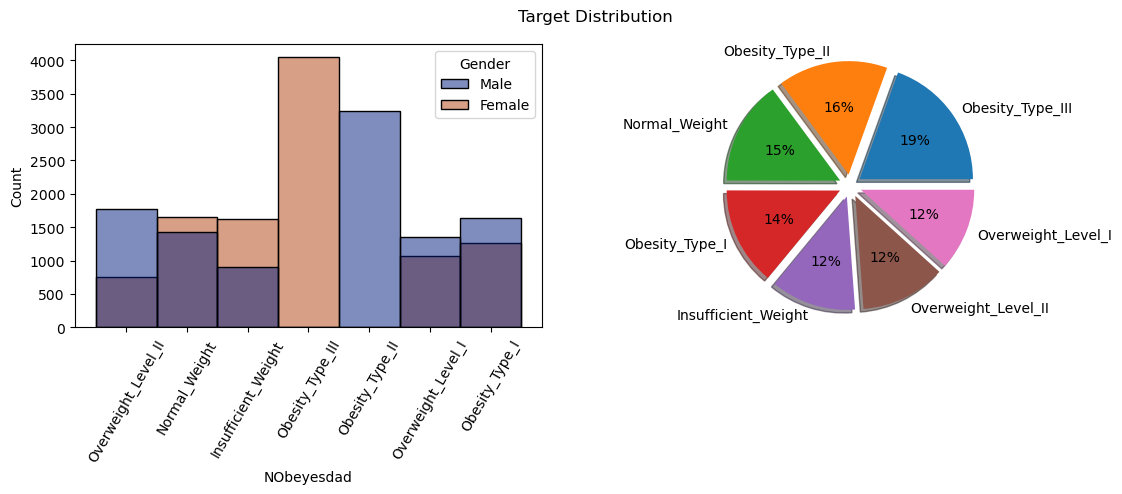

In [35]:
fig, axs = plt.subplots(1,2,figsize = (12,5))
plt.suptitle("Target Distribution")

sns.histplot(binwidth=0.5,x=TARGET,data=train,hue='Gender',palette="dark",ax=axs[0],discrete=True)
axs[0].tick_params(axis='x', rotation=60)

axs[1].pie(
        train[TARGET].value_counts(),
        shadow = True,
        explode=[.1 for i in range(train[TARGET].nunique())],
        labels = train[TARGET].value_counts().index,
        autopct='%1.f%%',
    )

plt.tight_layout()
plt.show()

<a id = "section_1"> </a>
# Individual Numerical Plots

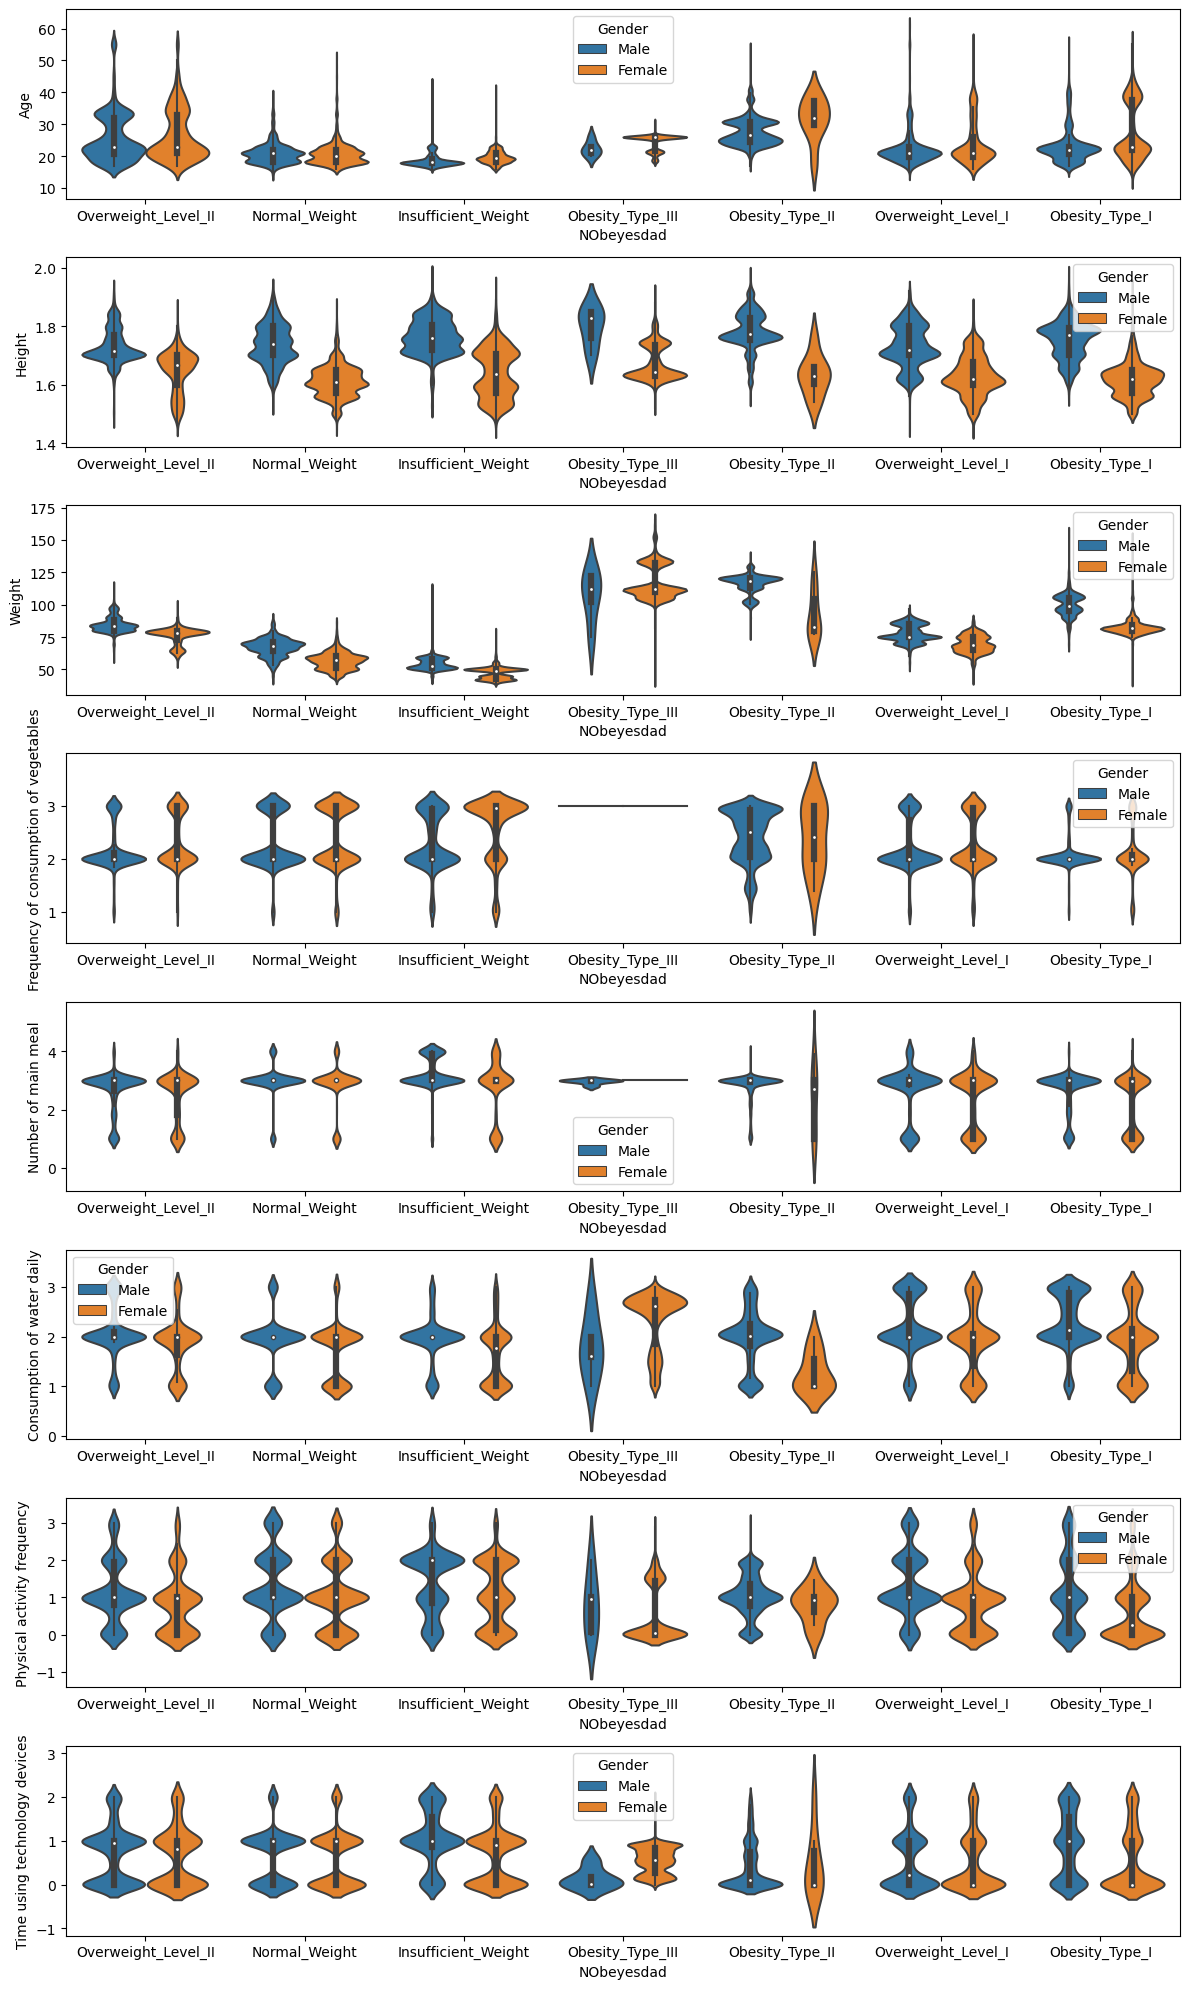

In [36]:
fig,axs = plt.subplots(len(raw_num_cols),1,figsize=(12,len(raw_num_cols)*2.5),sharex=False)
for i, col in enumerate(raw_num_cols):
    sns.violinplot(x=TARGET, y=col,hue="Gender", data=train,ax = axs[i], split=False)
    if col in full_form.keys():
        axs[i].set_ylabel(full_form[col])

plt.tight_layout()
plt.show()

Insights from above plots:
* We should Ignore, **Female** distribution in `Obesity_Type_II` Class & **Male** distribution in "Obesity_Type_III". because of very small sample size
* We can see People in category of `Insufficient Weight` consumes higher `Number of main Meal` maybe because to gain weight
* `Frequency of consumption of Vegetables` is **Three** for everyone in class `Obesity Type III`
* `Weight`, `Height` & `Gender` looks like the most important features. `Weight` shows very clear differentiation for diff classes

<a id = "section_2"> </a>
# Individual Categorical Plots

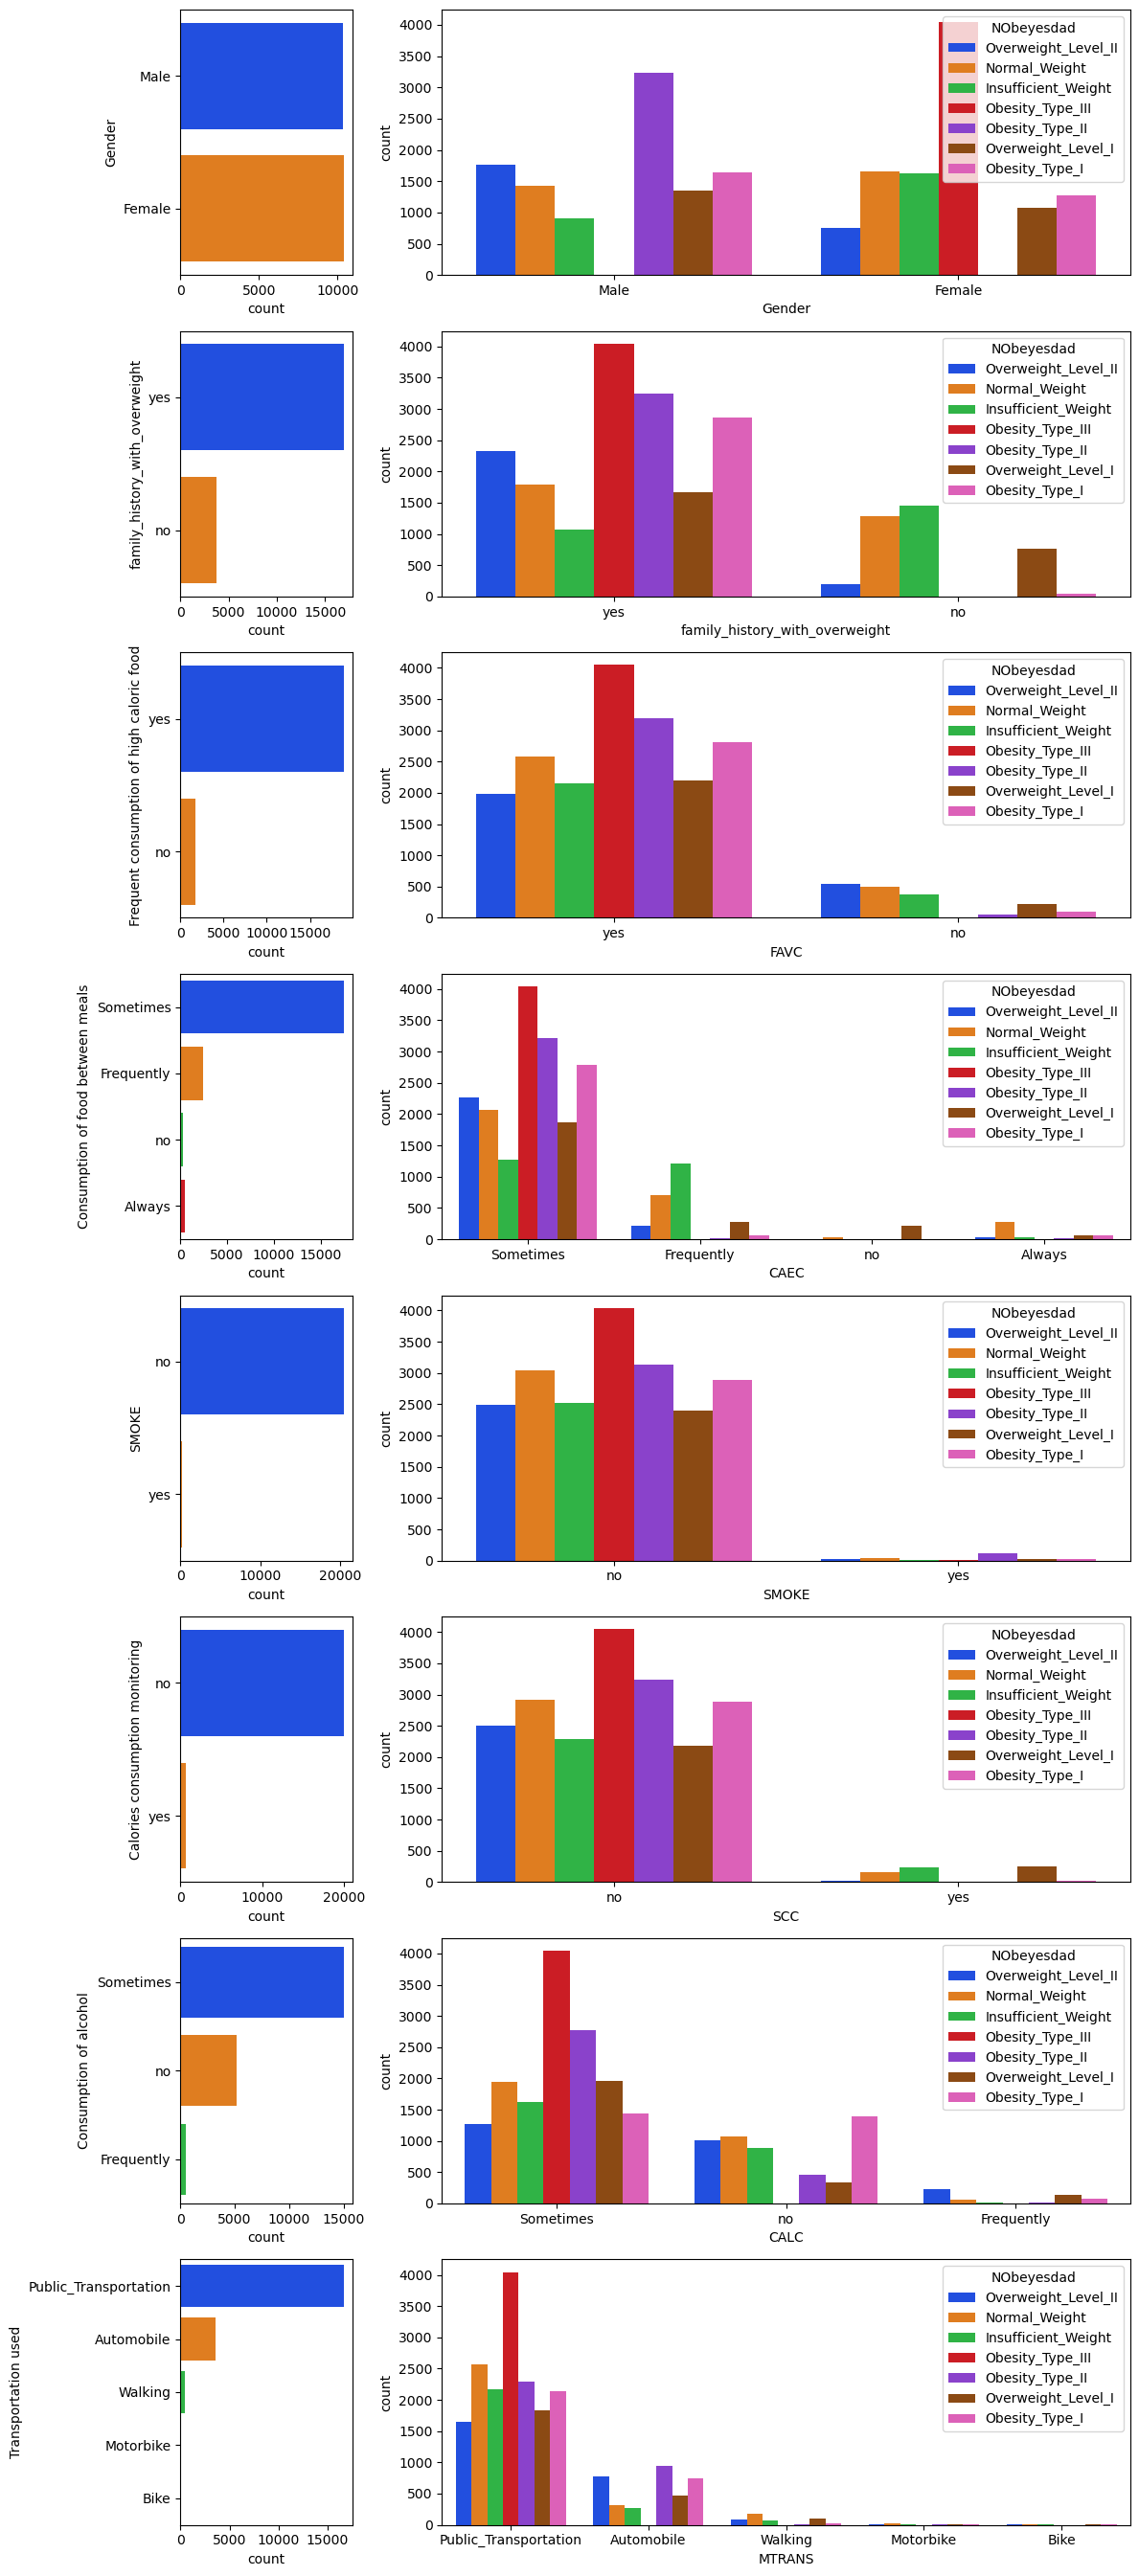

In [37]:
_,axs = plt.subplots(int(len(raw_cat_cols)-1),2,figsize=(12,len(raw_cat_cols)*3),width_ratios=[1, 4])
for i,col in enumerate(raw_cat_cols[1:]):
    sns.countplot(y=col,data=train,palette="bright",ax=axs[i,0])
    sns.countplot(x=col,data=train,hue=TARGET,palette="bright",ax=axs[i,1])
    if col in full_form.keys():
        axs[i,0].set_ylabel(full_form[col])


plt.tight_layout()
plt.show()


<a id = "section_3"></a>
# Numerical Correlation Plot

<AxesSubplot: >

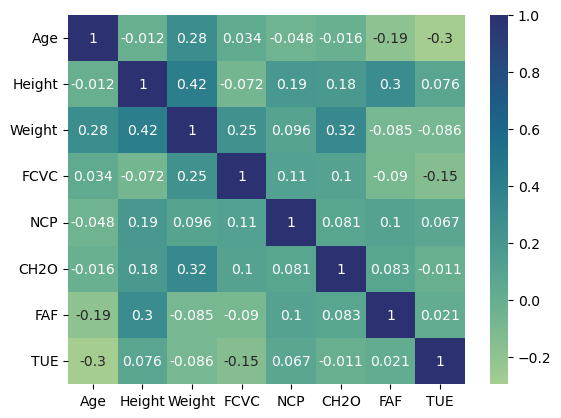

In [38]:
tmp = train[raw_num_cols].corr("pearson")
sns.heatmap(tmp,annot=True,cmap ="crest")

* `Height` has a positive corr with `Weight`,`FAF`. we will see there combined plots
* People with higher `Weight` drinks more water.


<a id = "section_4"></a>
# Combined Numerical Plots 

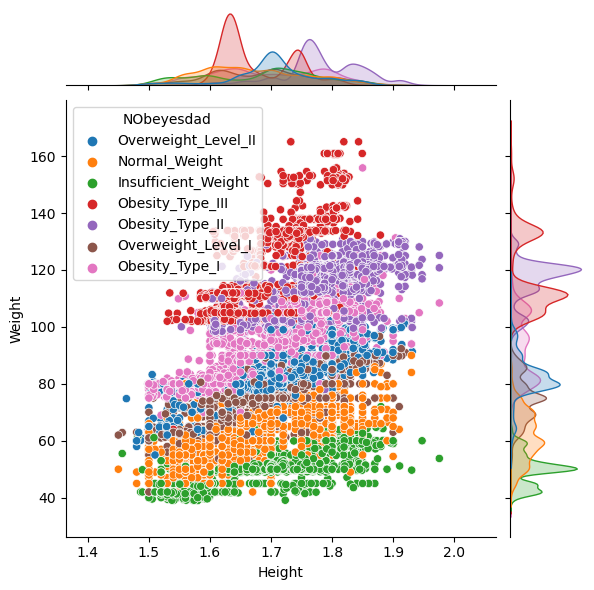

In [39]:
sns.jointplot(data=train, x="Height", y="Weight", hue=TARGET,height=6)

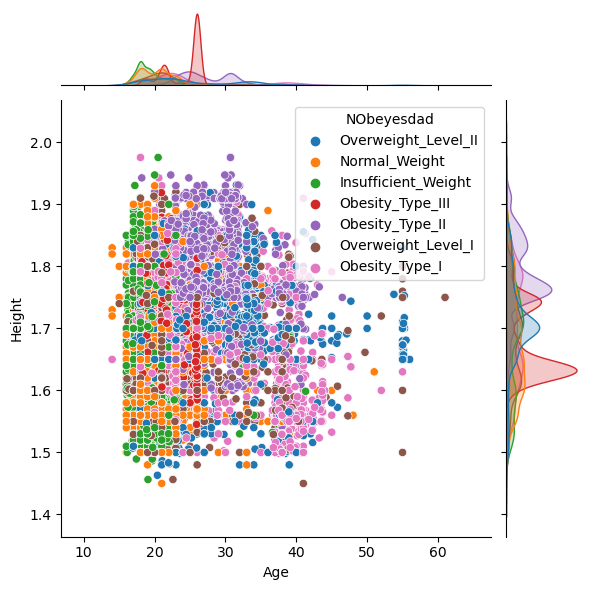

In [40]:
sns.jointplot(data=train, x="Age", y="Height", hue=TARGET,height=6)

In [ ]:
tmp

# Principal Component Analysis (PCA) & KMeans
These plots are inspired by [This](https://www.kaggle.com/competitions/playground-series-s4e2/discussion/472471) discussion.

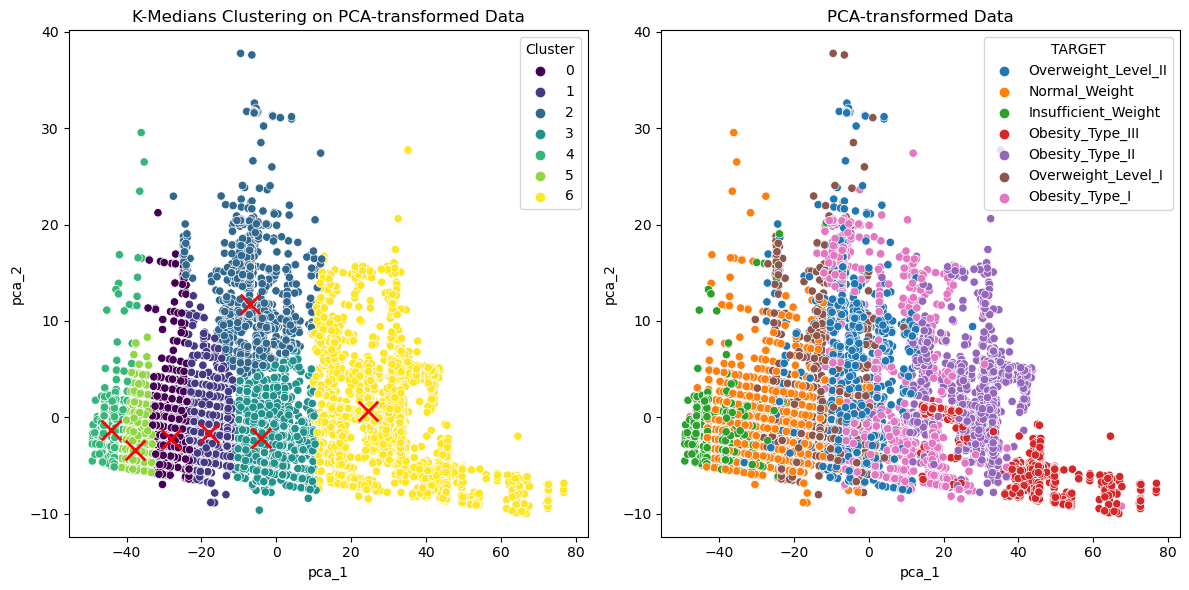

In [56]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#PCA
pca = PCA(n_components=2)
pca_top_2 = pca.fit_transform(train[raw_num_cols])

tmp = pd.DataFrame(data = pca_top_2, columns = ['pca_1','pca_2'])
tmp['TARGET'] = train[TARGET]


import numpy as np
from scipy.spatial.distance import cdist

def kmedians(X, k, max_iter=100):
    # Randomly initialize centroids
    centroids_idx = np.random.choice(len(X), k, replace=False)
    centroids = X[centroids_idx]
    
    for _ in range(max_iter):
        # Assign each point to the nearest centroid
        labels = np.argmin(cdist(X, centroids), axis=1)
        
        # Update centroids to the medians of points in each cluster
        new_centroids = np.array([np.median(X[labels == i], axis=0) for i in range(k)])
        
        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break
        
        centroids = new_centroids
    
    return labels, centroids

# Usage example
labels, centroids = kmedians(tmp[['pca_1', 'pca_2']].values, 7)

# Assign cluster labels to the DataFrame
tmp['Cluster'] = labels


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot K-Medians clustering with centroids
sns.scatterplot(data=tmp, x="pca_1", y="pca_2", hue='Cluster', palette='viridis', ax=axs[0])
axs[0].scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=200, linewidths=2)
axs[0].set_title('K-Medians Clustering on PCA-transformed Data')

# Plot PCA-transformed data colored by target
sns.scatterplot(data=tmp, y="pca_2", x="pca_1", hue='TARGET', ax=axs[1])
axs[1].set_title('PCA-transformed Data')

# Show the plot
plt.tight_layout()
plt.show()



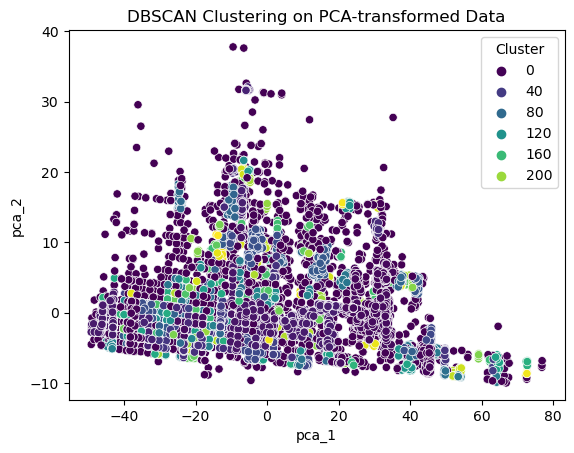

In [46]:
from sklearn.cluster import DBSCAN

# Perform DBSCAN clustering on the PCA-transformed data
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples according to your data
dbscan.fit(tmp[['pca_1', 'pca_2']])  # Fit DBSCAN to the PCA-transformed data

# Add cluster labels to the DataFrame
tmp['Cluster'] = dbscan.labels_

# Plot the clusters
sns.scatterplot(data=tmp, x="pca_1", y="pca_2", hue='Cluster', palette='viridis')
plt.title('DBSCAN Clustering on PCA-transformed Data')
plt.show()


# Feature Engineering & Processing

In [57]:
# In age_rounder, height_rounder func we multiply values
# by some value this sometimes improve model CV score
# In Extract features we combine features to get new features

def age_rounder(x):
    x_copy = x.copy()
    x_copy['Age'] = (x_copy['Age']*100).astype(np.uint16)
    return x_copy

def height_rounder(x):
    x_copy = x.copy()
    x_copy['Height'] = (x_copy['Height']*100).astype(np.uint16)
    return x_copy

def extract_features(x):
    x_copy = x.copy()
    x_copy['BMI'] = (x_copy['Weight']/x_copy['Height']**2)
#     x_copy['PseudoTarget'] = pd.cut(x_copy['BMI'],bins = [0,18.4,24.9,29,34.9,39.9,100],labels = [0,1,2,3,4,5],)    
    return x_copy

def col_rounder(x):
    x_copy = x.copy()
    cols_to_round = ['FCVC',"NCP","CH2O","FAF","TUE"]
    for col in cols_to_round:
        x_copy[col] = round(x_copy[col])
        x_copy[col] = x_copy[col].astype('int')
    return x_copy

AgeRounder = FunctionTransformer(age_rounder)
HeightRounder = FunctionTransformer(height_rounder)
ExtractFeatures = FunctionTransformer(extract_features)
ColumnRounder = FunctionTransformer(col_rounder)

In [58]:
# Using FeatureDropper we can drop columns. This is 
# important if we want to pass different set of features
# for different models

from sklearn.base import BaseEstimator, TransformerMixin
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self,x,y):
        return self
    def transform(self, x):
        return x.drop(self.cols, axis = 1)

### Next we will define `cross_val_model` which will be used to train and validate all the models we will use in this Notebook
`cross_val_model` function gives three things: **val_scores**, **valid_predictions**, **test_predictions**
* <b>val_scores:</b> This gives us accuracy score on Validation Data.
* <b>valid_predictions:</b> This is a array which stores model predictions on validation set
* <b>test_predictions:</b> This gives test prediction averaged by number of splits we are using

In [ ]:
# In cross_val_model we cross vaidate models using
# Stratified K-Fold.

# Encoding target values with int
target_mapping = {
                  'Insufficient_Weight':0,
                  'Normal_Weight':1,
                  'Overweight_Level_I':2,
                  'Overweight_Level_II':3, 
                  'Obesity_Type_I':4,
                  'Obesity_Type_II':5 ,
                  'Obesity_Type_III':6
                  }

# Define a method for Cross validation here we are using StartifiedKFold
skf = StratifiedKFold(n_splits=n_splits)

def cross_val_model(estimators,cv = skf, verbose = True):
    '''
        estimators : pipeline consists preprocessing, encoder & model
        cv : Method for cross validation (default: StratifiedKfold)
        verbose : print train/valid score (yes/no)
    '''
    
    X = train.copy()
    y = X.pop(TARGET)

    y = y.map(target_mapping)
    test_predictions = np.zeros((len(test),7))
    valid_predictions = np.zeros((len(X),7))

    val_scores, train_scores = [],[]
    for fold, (train_ind, valid_ind) in enumerate(skf.split(X,y)):
        model = clone(estimators)
        #define train set
        X_train = X.iloc[train_ind]
        y_train = y.iloc[train_ind]
        #define valid set
        X_valid = X.iloc[valid_ind]
        y_valid = y.iloc[valid_ind]

        model.fit(X_train, y_train)
        if verbose:
            print("-" * 100)
            print(f"Fold: {fold}")
            print(f"Train Accuracy Score:-{accuracy_score(y_true=y_train,y_pred=model.predict(X_train))}")
            print(f"Valid Accuracy Score:-{accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid))}")
            print("-" * 100)

        
        test_predictions += model.predict_proba(test)/cv.get_n_splits()
        valid_predictions[valid_ind] = model.predict_proba(X_valid)
        val_scores.append(accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid)))
    if verbose: 
        print(f"Average Mean Accuracy Score:- {np.array(val_scores).mean()}")
    return val_scores, valid_predictions, test_predictions

In [ ]:
#Combine Orignal & Synthetic Data

train.drop(['id'],axis = 1, inplace = True)
test_ids = test['id']
test.drop(['id'],axis = 1, inplace=True)

train = pd.concat([train,train_org],axis = 0)
train = train.drop_duplicates()
train.reset_index(drop=True, inplace=True)

In [ ]:
# empty dataframe to store score, & train / test predictions.
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# Model

<div style = "font-size:120%">Rather than focusing on a single model, in this competition it's better to combine predictions from many high performing models. In this notebook we will be training Four different type of models and will combine their predictions for final sub.</div>

* [Random Forest Model](#rfc)
* [LGBM Model](#lgbm)
* [XGB Model](#xgb)
* [Catboost Model](#cat)


<a id = "rfC"> </a>
# Random Forest Model

In [ ]:
# Define Random Forest Model Pipeline

RFC = make_pipeline(
                        ExtractFeatures,
                        MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                       RandomForestClassifier(random_state=RANDOM_SEED)
                    )

In [ ]:
# Execute Random Forest Pipeline
val_scores,val_predictions,test_predictions = cross_val_model(RFC)

# Save train/test predictions in dataframes
for k,v in target_mapping.items():
    oof_list[f"rfc_{k}"] = val_predictions[:,v]

for k,v in target_mapping.items():
    predict_list[f"rfc_{k}"] = test_predictions[:,v]
# 0.8975337326149792
# 0.9049682643904575

<a id = "lgbm"></a>
# LGBM Model

In [ ]:
# Define Optuna Function To Tune LGBM Model

def lgbm_objective(trial):
    params = {
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', .1, 15, log = True),
        'reg_lambda' : trial.suggest_float('reg_lambda', .1, 20, log = True),
        'reg_alpha' : trial.suggest_float('reg_alpha', .1, 10, log = True),
        'n_estimators' : 1000,
        'random_state' : RANDOM_SEED,
        'device_type' : "gpu",
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),

        #'boosting_type' : 'dart',
    }
    
    optuna_model = make_pipeline(
                                 ExtractFeatures,
                                 MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                                LGBMClassifier(**params,verbose=-1)
                                )
    val_scores, _, _ = cross_val_model(optuna_model,verbose = False)
    return np.array(val_scores).mean()

lgbm_study = optuna.create_study(direction = 'maximize',study_name="LGBM")

In [ ]:
# Execute LGBM Tuning, To Tune set `TUNE` to True (it will take a long time)
TUNE = False

warnings.filterwarnings("ignore")
if TUNE:
    lgbm_study.optimize(lgbm_objective, 50)


In [ ]:
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')

<div style = "font-size:120%">LGBM parameters in next cell are taken from @moazeldsokyx notebook you may check his great work in this notebook:<br></div>

https://www.kaggle.com/code/moazeldsokyx/pgs4e2-highest-score-lgbm-hyperparameter-tuning/notebook


In [ ]:
# Here we defined LGBM Pipeline
# Where we use One_Hot_Encoder, for categorical encoding
# standard scaler for numerical column scaling


params = {'learning_rate': 0.04325905707439143, 'max_depth': 4, 
          'subsample': 0.6115083405793659, 'min_child_weight': 0.43633356137010687, 
          'reg_lambda': 9.231766981717822, 'reg_alpha': 1.875987414096491, 'num_leaves': 373,
          'n_estimators' : 1000,'random_state' : RANDOM_SEED, 'device_type' : "gpu",
         }

best_params = {
    "objective": "multiclass",          # Objective function for the model
    "metric": "multi_logloss",          # Evaluation metric
    "verbosity": -1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 42,       # Random state for reproducibility
    "num_class": 7,                     # Number of classes in the dataset
    'learning_rate': 0.030962211546832760,  # Learning rate for gradient boosting
    'n_estimators': 500,                # Number of boosting iterations
    'lambda_l1': 0.009667446568254372,  # L1 regularization term
    'lambda_l2': 0.04018641437301800,   # L2 regularization term
    'max_depth': 10,                    # Maximum depth of the trees
    'colsample_bytree': 0.40977129346872643,  # Fraction of features to consider for each tree
    'subsample': 0.9535797422450176,    # Fraction of samples to consider for each boosting iteration
    'min_child_samples': 26             # Minimum number of data needed in a leaf
}

lgbm = make_pipeline(    
                        ColumnTransformer(
                        transformers=[('num', StandardScaler(), numerical_columns),
                                  ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_columns)]),
                        LGBMClassifier(**best_params,verbose=-1)
                    )

In [ ]:
# Train LGBM Model

val_scores,val_predictions,test_predictions = cross_val_model(lgbm)

for k,v in target_mapping.items():
    oof_list[f"lgbm_{k}"] = val_predictions[:,v]
    
for k,v in target_mapping.items():
    predict_list[f"lgbm_{k}"] = test_predictions[:,v]

#0.91420543252078

<a id = "xgb"></a>
# XGB Model

In [ ]:
# Optuna study for XGB Model
def xgb_objective(trial):
    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'gamma' : trial.suggest_float('gamma', 1e-9, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 0, 24),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
    }

    params['booster'] = 'gbtree'
    params['objective'] = 'multi:softmax'
    params["device"] = "cuda"
    params["verbosity"] = 0
    params['tree_method'] = "gpu_hist"
    
    
    optuna_model = make_pipeline(
#                     ExtractFeatures,
                    MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                    XGBClassifier(**params,seed=RANDOM_SEED)
                   )
    
    val_scores, _, _ = cross_val_model(optuna_model,verbose = False)
    return np.array(val_scores).mean()

xgb_study = optuna.create_study(direction = 'maximize')


In [ ]:
# Tune using Optuna
TUNE = False
if TUNE:
    xgb_study.optimize(xgb_objective, 50)

In [ ]:
# XGB Pipeline

params = {
    'n_estimators': 1312,
    'learning_rate': 0.018279520260162645,
    'gamma': 0.0024196354156454324,
    'reg_alpha': 0.9025931173755949,
    'reg_lambda': 0.06835667255875388,
    'max_depth': 5,
    'min_child_weight': 5,
    'subsample': 0.883274050086088,
    'colsample_bytree': 0.6579828557036317
}
# {'eta': 0.018387615982905264, 'max_depth': 29, 'subsample': 0.8149303101087905, 'colsample_bytree': 0.26750463604831476, 'min_child_weight': 0.5292380065098192, 'reg_lambda': 0.18952063379457604, 'reg_alpha': 0.7201451827004944}

params = {'grow_policy': 'depthwise', 'n_estimators': 690, 
               'learning_rate': 0.31829021594473056, 'gamma': 0.6061120644431842, 
               'subsample': 0.9032243794829076, 'colsample_bytree': 0.44474031945048287,
               'max_depth': 10, 'min_child_weight': 22, 'reg_lambda': 4.42638097284094,
               'reg_alpha': 5.927900973354344e-07,'seed':RANDOM_SEED}

best_params = {'grow_policy': 'depthwise', 'n_estimators': 982, 
               'learning_rate': 0.050053726931263504, 'gamma': 0.5354391952653927, 
               'subsample': 0.7060590452456204, 'colsample_bytree': 0.37939433412123275, 
               'max_depth': 23, 'min_child_weight': 21, 'reg_lambda': 9.150224029846654e-08,
               'reg_alpha': 5.671063656994295e-08}
best_params['booster'] = 'gbtree'
best_params['objective'] = 'multi:softmax'
best_params["device"] = "cuda"
best_params["verbosity"] = 0
best_params['tree_method'] = "gpu_hist"
    
XGB = make_pipeline(
#                     ExtractFeatures,
#                     MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
#                                            'SMOKE','SCC','CALC','MTRANS']),
#                     FeatureDropper(['FAVC','FCVC']),
#                     ColumnRounder,
#                     ColumnTransformer(
#                     transformers=[('num', StandardScaler(), numerical_columns),
#                                   ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_columns)]),
                    MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                    XGBClassifier(**best_params,seed=RANDOM_SEED)
                   )

In [ ]:
val_scores,val_predictions,test_predictions = cross_val_model(XGB)

for k,v in target_mapping .items():
    oof_list[f"xgb_{k}"] = val_predictions[:,v]

for k,v in target_mapping.items():
    predict_list[f"xgb_{k}"] = test_predictions[:,v]
    
# 0.90634942296329
#0.9117093455898445 with rounder
#0.9163506382522121

<a id = "cat"></a>
# Catboost Model


In [ ]:
# Optuna Function For Catboost Model
def cat_objective(trial):
    
    params = {
        
        'iterations': 1000,  # High number of estimators
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_seed': RANDOM_SEED,
        'verbose': False,
        'task_type':"GPU"
    }
    
    cat_features = ['Gender','family_history_with_overweight','FAVC','FCVC','NCP',
                'CAEC','SMOKE','CH2O','SCC','FAF','TUE','CALC','MTRANS']
    optuna_model = make_pipeline(
                        ExtractFeatures,
#                         AgeRounder,
#                         HeightRounder,
#                         MEstimateEncoder(cols = raw_cat_cols),
                        CatBoostClassifier(**params,cat_features=cat_features)
                        )
    val_scores,_,_ = cross_val_model(optuna_model,verbose = False)
    return np.array(val_scores).mean()
    
cat_study = optuna.create_study(direction = 'maximize')

In [ ]:
params = {'learning_rate': 0.13762007048684638, 'depth': 5, 
          'l2_leaf_reg': 5.285199432056192, 'bagging_temperature': 0.6029582154263095,
         'random_seed': RANDOM_SEED,
        'verbose': False,
        'task_type':"GPU",
         'iterations':1000}


CB = make_pipeline(
#                         ExtractFeatures,
#                         AgeRounder,
#                         HeightRounder,
#                         MEstimateEncoder(cols = raw_cat_cols),
#                         CatBoostEncoder(cols = cat_features),
                        CatBoostClassifier(**params, cat_features=categorical_columns)
                        )

In [ ]:
# Train Catboost Model
val_scores,val_predictions,test_predictions = cross_val_model(CB)
for k,v in target_mapping.items():
    oof_list[f"cat_{k}"] = val_predictions[:,v]

for k,v in target_mapping.items():
    predict_list[f"cat_{k}"] = test_predictions[:,v]

# best 0.91179835368868 with extract features, n_splits = 10
# best 0.9121046227778054 without extract features, n_splits = 10

# Model Evaluation

In [ ]:
# skf = StratifiedKFold(n_splits=5)
weights = {"rfc_":0,
           "lgbm_":3,
           "xgb_":1,
           "cat_":0}
tmp = oof_list.copy()
for k,v in target_mapping.items():
    tmp[f"{k}"] = (weights['rfc_']*tmp[f"rfc_{k}"] +
              weights['lgbm_']*tmp[f"lgbm_{k}"]+
              weights['xgb_']*tmp[f"xgb_{k}"]+
              weights['cat_']*tmp[f"cat_{k}"])    
tmp['pred'] = tmp[target_mapping.keys()].idxmax(axis = 1)
tmp['label'] = train[TARGET]
print(f"Ensemble Accuracy Scoe: {accuracy_score(train[TARGET],tmp['pred'])}")
    
cm = confusion_matrix(y_true = tmp['label'].map(target_mapping),
                      y_pred = tmp['pred'].map(target_mapping),
                     normalize='true')

cm = cm.round(2)
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = target_mapping.keys())
disp.plot(xticks_rotation=50)
plt.tight_layout()
plt.show()

"""   BEST     """

# Best LB [0,1,0,0]
# Average Train Score:0.9142044335854003
# Average Valid Score:0.91420543252078

# Best CV [1,3, 1,1]
# Average Train Score:0.9168308163711971
# Average Valid Score:0.9168308163711971
# adding orignal data improves score

# Final Submission

In [ ]:
weights

In [ ]:
for k,v in target_mapping.items():
    predict_list[f"{k}"] = (weights['rfc_']*predict_list[f"rfc_{k}"]+
                            weights['lgbm_']*predict_list[f"lgbm_{k}"]+
                            weights['xgb_']*predict_list[f"xgb_{k}"]+
                            weights['cat_']*predict_list[f"cat_{k}"])

final_pred = predict_list[target_mapping.keys()].idxmax(axis = 1)

sample_sub[TARGET] = final_pred
sample_sub.to_csv("submission.csv",index=False)
sample_sub


### Feel free to fork and test different things. some of the things you may try:
* Try Different weights and see how CV & LB changes. weights = {'rfc_': 0.0, 'lgbm_': 1.0, 'xgb_': 0.0, 'cat_': 0.0} gives best LB. you may try that first
* In this Notebook we used `StandardScaler`, next we can try `Log & MinMax Scaler transformer`
* Define new features in `extract_feature` function by combining different features
* Tune the models again using Optuna
* In this notebook we are using weighted average, next we may use a linear model to combine the predictions.

**This notebook is inspired by the awesome work of Iqbal Syah Akbar. I highly recommend to check his work.**

https://www.kaggle.com/code/iqbalsyahakbar/ps4e1-3rd-place-solution





**Happy Coding !!**
